##### Copyright 2025 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Get started with Video generation using Veo

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started_Veo.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

_If you're reading this notebook on Github, open it in Colab by clicking the above button to see the generated videos._

<!-- Princing warning Badge -->
<table>
  <tr>
    <!-- Emoji -->
    <td bgcolor="#f5949e">
      <font size=30>⚠️</font>
    </td>
    <!-- Text Content Cell -->
    <td bgcolor="#f5949e">
      <h3><font color=black>Veo is a paid only feature. It won't run with the Free Tier.<br>  
      (cf. <a href="https://ai.google.dev/pricing#veo2"><font color='#217bfe'>pricing</font></a> for more details).</font></h3>
    </td>
  </tr>
</table>

In [ ]:
# Change that value if you want to run the colab
I_am_aware_that_veo_is_a_paid_feature = False # @param {type:"boolean"}

## Why Veo

Veo enables developers to create high quality videos with incredible detail, minimal artifacts, and extended durations in resolutions up to 720p. Veo supports both text-to-video and image-to-video.

With [Veo 3](https://ai.google.dev/gemini-api/docs/video), developers can create videos with:
* **Advanced language understanding**: Veo deeply understands natural language and visual semantics, capturing the nuance and tone of complex prompts to render intricate details in extended scenes, including cinematic terms like "timelapse" or "aerial shots."
* **Unprecedented creative control**: Veo provides an unprecedented level of creative control, understanding prompts for all kinds of cinematic effects, like timelapses or aerial shots of a landscape.
* **Videos with audio**: Veo 3 generates videos with audio automatically, with no additional effort from the developer.
* **More accurate video controls**: Veo 3 is more accurate on lighting, accurate physics, and camera controls.

The Veo 3 family of models includes both [**Veo 3**](https://ai.google.dev/gemini-api/docs/video?example=dialogue#veo-3) as well as [**Veo 3 Fast**](https://ai.google.dev/gemini-api/docs/video?example=dialogue#veo-3-fast), which is a faster and more accessible version of Veo 3. Veo 3 Fast is ideal for backend services that programmatically generate ads, tools for rapid A/B testing of creative concepts, or apps that need to quickly produce social media content.

Note that the previous model generation, [**Veo 2**](https://ai.google.dev/gemini-api/docs/video?example=dialogue#veo-2), is still available for developers via the Gemini API. However, unlike Veo 3, videos generated by Veo 2 do not contain audio.

## Setup

### Install SDK

Install the SDK from [PyPI](https://github.com/googleapis/python-genai).

In [ ]:
%pip install -U -q "google-genai>1.8.0"

### Setup your API key and initialize client

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication](../quickstarts/Authentication.ipynb) for an example.

In [ ]:
from google.colab import userdata
from google import genai
from google.genai import types

GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
client = genai.Client(api_key=GEMINI_API_KEY)

## Experimenting with Veo

Describe your desired scene, whether crafted by you or with Gemini's assistance, and Veo 3 brings it to life.

**Safety is a core focus**, with robust measures to prevent inappropriate or harmful content, and all generated videos are digitally watermarked with [Google DeepMind’s SynthID](https://deepmind.google/science/synthid/).


### Select the Veo 3 model

In [ ]:
VEO_MODEL_ID = "veo-3.0-fast-generate-001" # @param ['veo-2.0-generate-001', 'veo-3.0-fast-generate-001', 'veo-3.0-generate-001'] {"allow-input":true, isTemplate: true}

### Text-to-video

Veo 3 can generate videos from text prompts (see in the code comments for ideas).

#### Prompting Tips for Veo
To get the most out of Veo, consider incorporating specific video terminology into your prompts.  Veo understands a wide range of terms related to:

* **Shot composition**: Specify the framing and number of subjects in the shot (e.g., "*single shot*", "*two shot*", "*over-the-shoulder shot*").
* **Camera positioning and movement**:  Control the camera's location and movement using terms like "*eye level*", "*high angle*", "*worms eye*", "*dolly shot*", "*zoom shot*", "*pan shot," and "*tracking shot*".
* **Focus and lens effects**:  Use terms like "*shallow focus*", "*deep focus*", "*soft focus*", "*macro lens*", and "*wide-angle lens*" to achieve specific visual effects.
* **Overall style and subject**: Guide Veo's creative direction by specifying styles like "*sci-fi*", "*romantic comedy*", "*action movie*" or "*animation*". You can also describe the subjects and backgrounds you want, such as "*cityscape*", "*nature*", "*vehicles*", or "animals."

Check the [Veo prompt guide](https://ai.google.dev/gemini-api/docs/video/veo-prompt-guide) for more details and tips.

#### Optional parameters for Veo 3
The prompt is the only mandatory parameters, the others are all optional.

* **negative_prompt**: What you don't want to see in the video,
* **person_generation**: Tell you model if it's allowed to generate adults in the videos or not. Children are always blocked,
* **number_of_videos**: With Veo 3, it is always a single shot generation (one video generated),
* **duration_seconds**: With Veo 3, it is always 8 seconds long videos generated,
* **aspect ratio**: Either `16:9` (landscape) or `9:16` (portrait),
* **resolution**: Either `720p` or `1080p` (only in 16:9)

#### A video creation from a simple text prompt

It takes about a minute for the video to be generated.

In [ ]:
if not I_am_aware_that_veo_is_a_paid_feature:
  print("Veo is a paid feature. Please change the variable 'I_am_aware_that_veo_is_a_paid_feature' to True if you are okay with paying to run it.")

else:
  import time
  from IPython.display import Video, HTML

  prompt = "a close-up shot of a golden retriever playing in a field of sunflowers" # @param {type: "string"}

  # Optional parameters
  negative_prompt = "barking, woofing" # @param {type: "string"}
  aspect_ratio = "16:9" # @param ["16:9","9:16"]
  resolution = "1080p" # @param ["720p","1080p"]

  operation = client.models.generate_videos(
      model=VEO_MODEL_ID,
      prompt=prompt,
      config=types.GenerateVideosConfig(
        # At the moment the config must not be empty
        aspect_ratio=aspect_ratio,
        resolution=resolution,
        number_of_videos=1, # 1 video generated per request
        negative_prompt=negative_prompt,
      ),
  )

  # Waiting for the video(s) to be generated
  while not operation.done:
      time.sleep(20)
      operation = client.operations.get(operation)
      print(operation)

  print(operation.result.generated_videos)

  for n, generated_video in enumerate(operation.result.generated_videos):
    client.files.download(file=generated_video.video)
    generated_video.video.save(f'video{n}.mp4') # Saves the video(s)
    display(generated_video.video.show()) # Displays the video(s) in a notebook

##### Watch a sample generation 🎥

🍿 The video you will generate will be similar to this: [A golden retriever playing in a field of sunflowers](https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/dog_sunflowers.mp4).

<video controls src="https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/dog_sunflowers.mp4">

#### Working with lighting controls

Veo 3 also allows you to have a good control on the lighing of the video being generated.

In [ ]:
if not I_am_aware_that_veo_is_a_paid_feature:
  print("Veo is a paid feature. Please change the variable 'I_am_aware_that_veo_is_a_paid_feature' to True if you are okay with paying to run it.")

else:
  import time
  from google.genai import types
  from IPython.display import Video, HTML

  prompt = "a solitary, ancient oak tree silhouetted against a dramatic sunset. Emphasize the exquisite control over lighting: capture the deep, warm hues of the setting sun backlighting the tree, with subtle rays of light piercing through the branches, highlighting the texture of the bark and leaves with a golden glow. The sky should transition from fiery orange at the horizon to soft purples and blues overhead, with a single, faint star appearing as dusk deepens. Include the gentle sound of a breeze rustling through the leaves, and the distant call of an owl." # @param {type: "string"}

  # Optional parameters
  negative_prompt = "" # @param {type: "string"}
  aspect_ratio = "16:9" # @param ["16:9","9:16"]
  resolution = "1080p" # @param ["720p","1080p"]

  operation = client.models.generate_videos(
      model=VEO_MODEL_ID,
      prompt=prompt,
      config=types.GenerateVideosConfig(
        # At the moment the config must not be empty
        aspect_ratio=aspect_ratio,
        resolution=resolution,
        number_of_videos=1, # 1 video generated per request
        negative_prompt=negative_prompt,
      ),
  )

  # Waiting for the video(s) to be generated
  while not operation.done:
      time.sleep(20)
      operation = client.operations.get(operation)
      print(operation)

  print(operation.result.generated_videos)

  for n, generated_video in enumerate(operation.result.generated_videos):
    client.files.download(file=generated_video.video)
    generated_video.video.save(f'video{n}.mp4') # Saves the video(s)
    display(generated_video.video.show()) # Displays the video(s) in a notebook

##### Watch a sample generation 🎥

🍿 The video you will generate will be similar to this: [A solitary, ancient oak tree silhouetted against a dramatic sunset](https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/lighting_control.mp4).

<video controls src="https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/lighting_control.mp4">

#### Working with camera controls

Veo 3 also allows you to have a good control on the camera shots and behavior of the video being generated.

In [ ]:
if not I_am_aware_that_veo_is_a_paid_feature:
  print("Veo is a paid feature. Please change the variable 'I_am_aware_that_veo_is_a_paid_feature' to True if you are okay with paying to run it.")

else:
  import time
  from google.genai import types
  from IPython.display import Video, HTML

  prompt = "a realistic video of a futuristic red sportscar speeding down a winding coastal highway at dusk. Begin with a high-angle drone shot that slowly descends, transitioning into a close-up, low-angle tracking shot that perfectly follows the car as it rounds a curve, emphasizing its speed and the gleam of its paint under the fading light. Then, execute a smooth, rapid dolly zoom, making the background compress as the car remains the same size, conveying a sense of intense focus and speed. Finally, end with a perfectly stable, slow-motion shot from a fixed roadside perspective as the car blurs past, its taillights streaking across the frame. Include the immersive sound of the engine roaring, the tires gripping the asphalt, and the distant crash of waves." # @param {type: "string"}

  # Optional parameters
  negative_prompt = "" # @param {type: "string"}
  aspect_ratio = "16:9" # @param ["16:9","9:16"]
  resolution = "1080p" # @param ["720p","1080p"]

  operation = client.models.generate_videos(
      model=VEO_MODEL_ID,
      prompt=prompt,
      config=types.GenerateVideosConfig(
        # At the moment the config must not be empty
        aspect_ratio=aspect_ratio,
        resolution=resolution,
        number_of_videos=1, # 1 video generated per request
        negative_prompt=negative_prompt,
      ),
  )

  # Waiting for the video(s) to be generated
  while not operation.done:
      time.sleep(20)
      operation = client.operations.get(operation)
      print(operation)

  print(operation.result.generated_videos)

  for n, generated_video in enumerate(operation.result.generated_videos):
    client.files.download(file=generated_video.video)
    generated_video.video.save(f'video{n}.mp4') # Saves the video(s)
    display(generated_video.video.show()) # Displays the video(s) in a notebook

##### Watch a sample generation 🎥

🍿 The video you will generate will be similar to this: [a futuristic red sportscar speeding down a winding coastal highway](https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/camera_control.mp4).

<video controls src="https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/camera_control.mp4">

#### Working with audio controls

Veo 3 also allows you to control audio details on your generated video.

In [ ]:
if not I_am_aware_that_veo_is_a_paid_feature:
  print("Veo is a paid feature. Please change the variable 'I_am_aware_that_veo_is_a_paid_feature' to True if you are okay with paying to run it.")

else:
  import time
  from google.genai import types
  from IPython.display import Video, HTML

  prompt = "fireworks at a beautiful city skyline scene with many different fireworks colors and sounds. sounds from excited people enjoying the show surrounding the camera POV can be heard too." # @param {type: "string"}

  # Optional parameters
  negative_prompt = "" # @param {type: "string"}
  aspect_ratio = "16:9" # @param ["16:9","9:16"]
  resolution = "1080p" # @param ["720p","1080p"]

  operation = client.models.generate_videos(
      model=VEO_MODEL_ID,
      prompt=prompt,
      config=types.GenerateVideosConfig(
        # At the moment the config must not be empty
        aspect_ratio=aspect_ratio,
        resolution=resolution,
        number_of_videos=1, # 1 video generated per request
        negative_prompt=negative_prompt,
      ),
  )

  # Waiting for the video(s) to be generated
  while not operation.done:
      time.sleep(20)
      operation = client.operations.get(operation)
      print(operation)

  print(operation.result.generated_videos)

  for n, generated_video in enumerate(operation.result.generated_videos):
    client.files.download(file=generated_video.video)
    generated_video.video.save(f'video{n}.mp4') # Saves the video(s)
    display(generated_video.video.show()) # Displays the video(s) in a notebook

##### Watch a sample generation 🎥

🍿 The video you will generate will be similar to this: [fireworks at a beautiful city skyline scene](https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/audio_control.mp4).

<video controls src="https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/audio_control.mp4">

#### Working with dialogs

You have the flexibility to define the dialog on your videos too.

In [ ]:
if not I_am_aware_that_veo_is_a_paid_feature:
  print("Veo is a paid feature. Please change the variable 'I_am_aware_that_veo_is_a_paid_feature' to True if you are okay with paying to run it.")

else:
  import time
  from google.genai import types
  from IPython.display import Video, HTML

  prompt = "Two charismatic and funny raindrops like coloured characters. The first character start saying \"oh my god, it is really hot in here!\" - then the second answers \"right? I'm melting down! then it melts down completely." # @param {type: "string"}

  # Optional parameters
  negative_prompt = "texts, captions, subtitles" # @param {type: "string"}
  aspect_ratio = "16:9" # @param ["16:9","9:16"]
  resolution = "1080p" # @param ["720p","1080p"]

  operation = client.models.generate_videos(
      model=VEO_MODEL_ID,
      prompt=prompt,
      config=types.GenerateVideosConfig(
        # At the moment the config must not be empty
        aspect_ratio=aspect_ratio,
        resolution=resolution,
        number_of_videos=1, # 1 video generated per request
        negative_prompt=negative_prompt,
      ),
  )

  # Waiting for the video(s) to be generated
  while not operation.done:
      time.sleep(20)
      operation = client.operations.get(operation)
      print(operation)

  print(operation.result.generated_videos)

  for n, generated_video in enumerate(operation.result.generated_videos):
    client.files.download(file=generated_video.video)
    generated_video.video.save(f'video{n}.mp4') # Saves the video(s)
    display(generated_video.video.show()) # Displays the video(s) in a notebook

##### Watch a sample generation 🎥

🍿 The video you will generate will be similar to this: [A dialog of two charismatic and funny raindrops like coloured characters](https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/dialog_control.mp4).

<video controls src="https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/dialog_control.mp4">

### Image-to-video

You can also generate videos from an base image and a prompt. Here are two examples, one in which you provide the image and one in which you will use Imagen to generate the image.


#### Using your own images

If you want to use your own image, upload it to colab by clicking on the **folder icon** in the left menu (it should be the 5th choice), then on the **upload icon** (the first one) at the top of left left panel that should have been opened.

Your images will be uploaded in the `/content` folder of this colab instance.

Alternatively, you can use the code in this cell to upload your image:

In [ ]:
import os

from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
  os.rename(fn, 'image.jpg')

Saving ginger.jpeg to ginger.jpeg


Now that you have your own image, you can add it to your Veo prompt.

If you don't know what to prompt about your image, keep the prompt empty and the model will figure out what to generate.


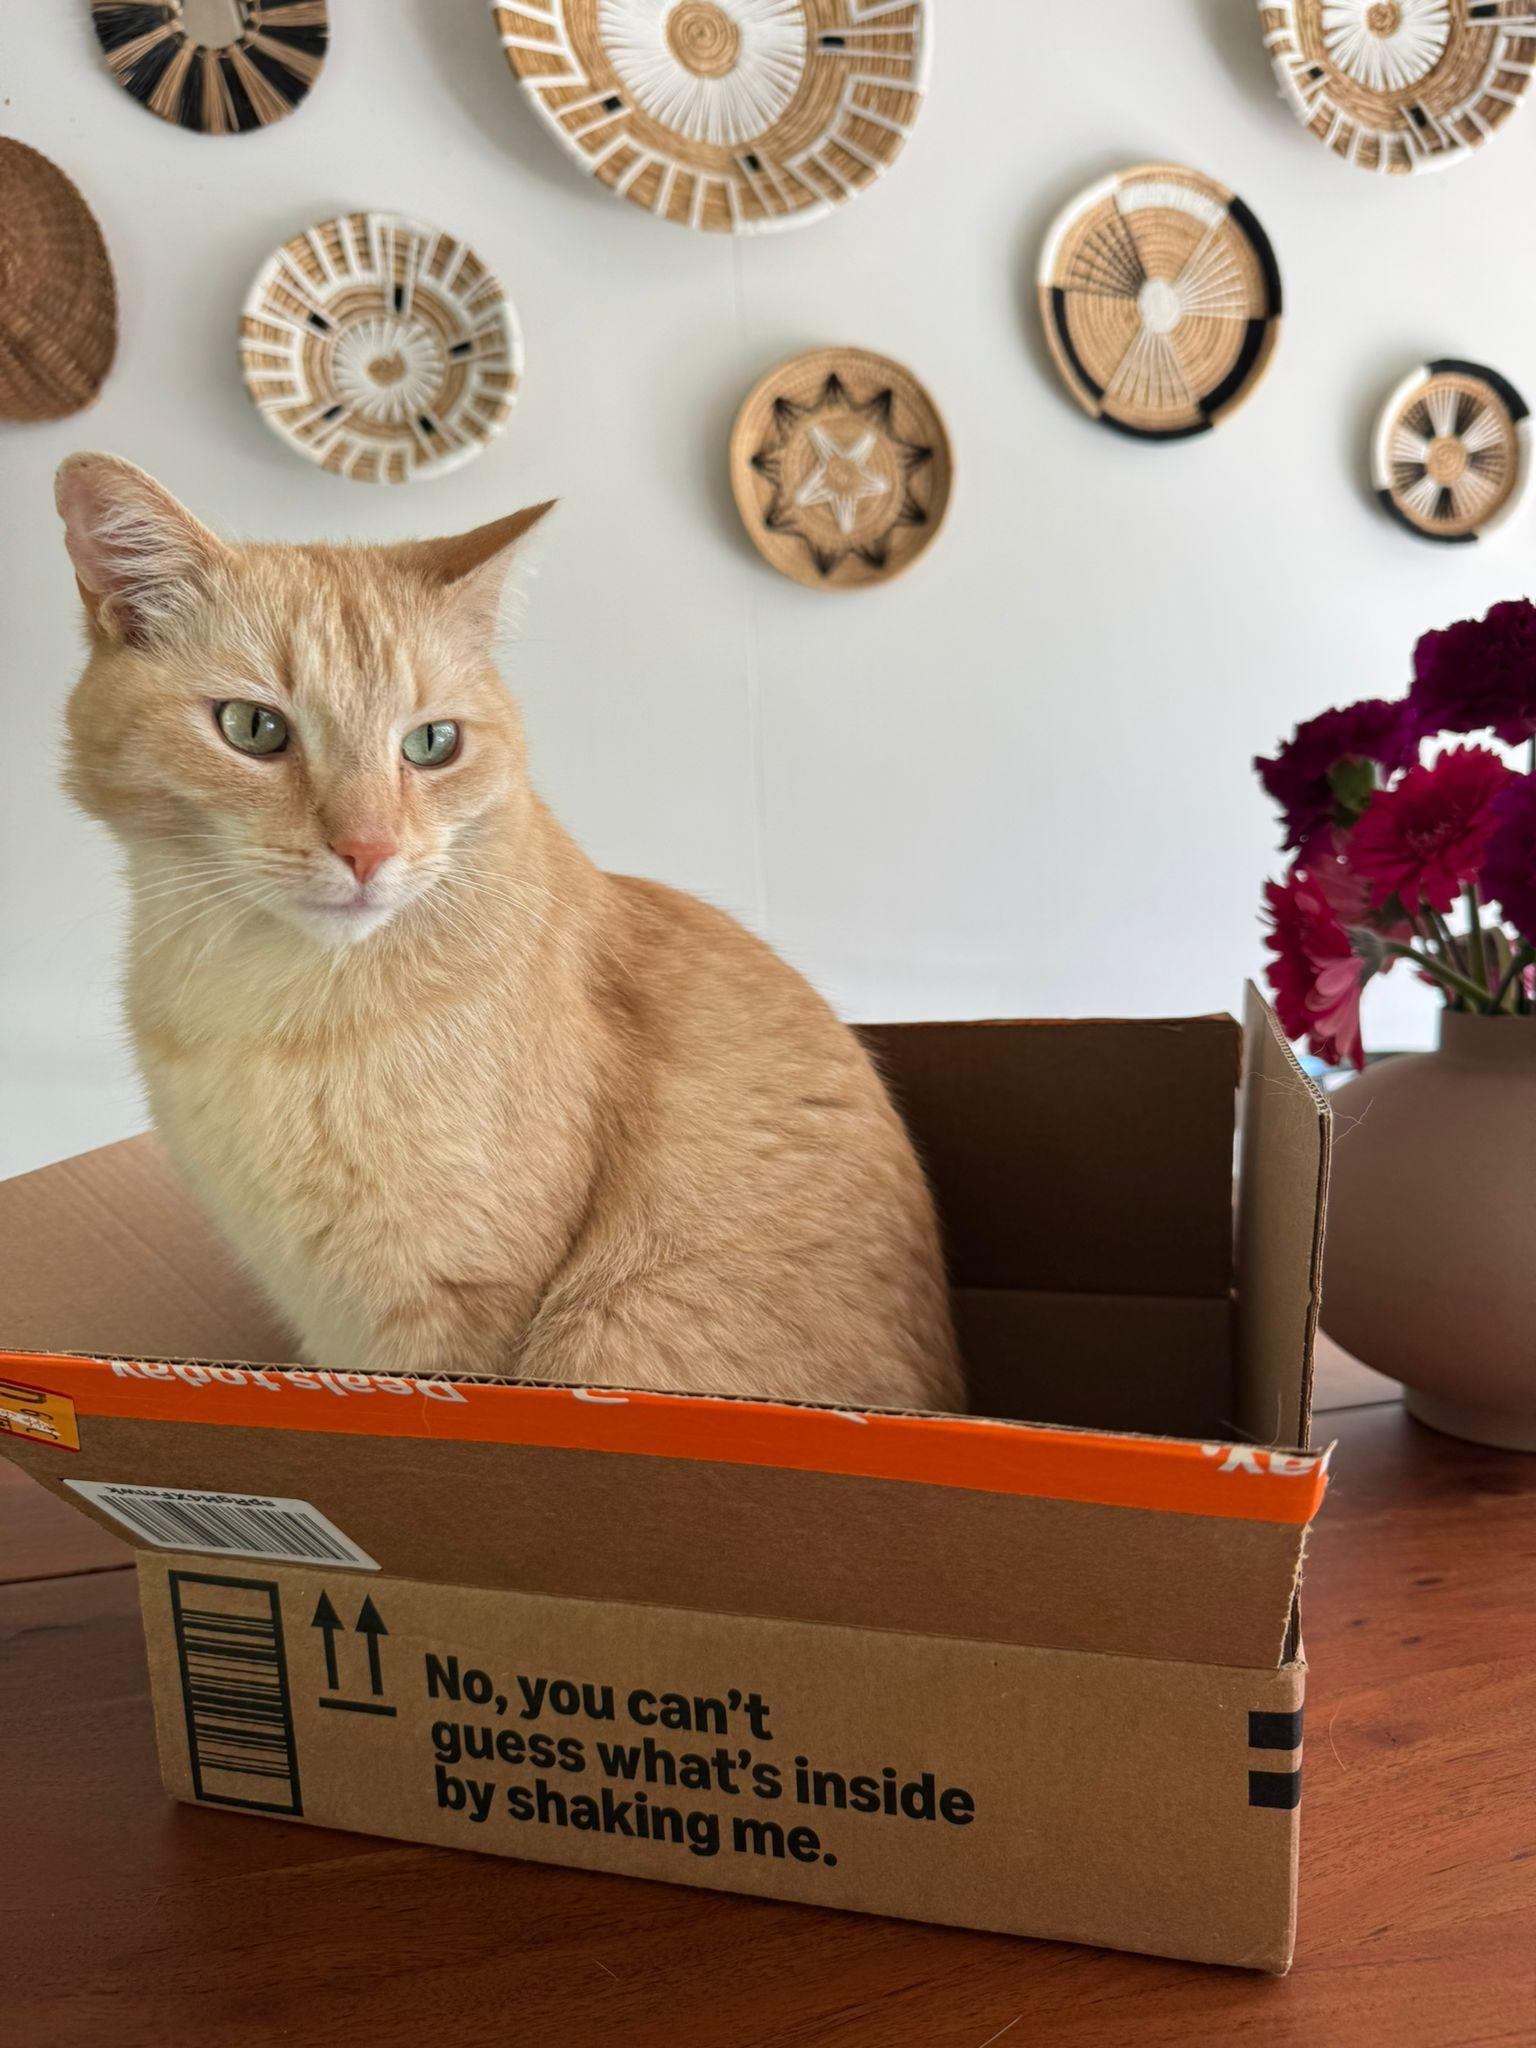

In [ ]:
from IPython.display import Image as Img

display(Img('image.jpg', width=600)) # display the uploaded image

In [ ]:
if not I_am_aware_that_veo_is_a_paid_feature:
  print("Veo is a paid feature. Please change the variable 'I_am_aware_that_veo_is_a_paid_feature' to True if you are okay with paying to run it.")

else:
  import time
  from google.genai import types
  from IPython.display import Video, HTML
  from PIL import Image
  import io

  prompt = "" # @param {"type":"string","placeholder":"Write your own prompt or leave empty to let the model decide"}
  image_name = "" # @param {type: "string", "placeholder":"Enter the name of your image or leave empty for the one you just uploaded."}

  # Optional parameters
  negative_prompt = "ugly, low quality" # @param {type: "string"}
  aspect_ratio = "9:16" # @param ["16:9","9:16"]
  resolution = "720p" # @param ["720p","1080p"]

  # Loading the image
  if image_name=="":
    image_name = "image.jpg"
  im = Image.open(image_name)

  # converting the image to bytes
  image_bytes_io = io.BytesIO()
  im.save(image_bytes_io, format=im.format)
  image_bytes = image_bytes_io.getvalue()

  operation = client.models.generate_videos(
      model=VEO_MODEL_ID,
      prompt=prompt,
      image=types.Image(image_bytes=image_bytes, mime_type=im.format),
      config=types.GenerateVideosConfig(
        # At the moment the config must not be empty
        aspect_ratio=aspect_ratio,
        resolution=resolution,
        number_of_videos=1, # 1 video generated per request
        negative_prompt=negative_prompt,
      ),
  )

  # Waiting for the video(s) to be generated
  while not operation.done:
      time.sleep(20)
      operation = client.operations.get(operation)
      print(operation)

  print(operation.result.generated_videos)

  for n, generated_video in enumerate(operation.result.generated_videos):
    client.files.download(file=generated_video.video)
    generated_video.video.save(f'video{n}.mp4') # Saves the video(s)
    display(generated_video.video.show()) # Displays the video(s) in a notebook

##### Watch a sample generation 🎥

🍿 The video you will generate will be similar to this: [A video generated from the uploaded image](https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/video_from_img.mp4).

<video controls src="https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/video_from_img.mp4">

#### Using Imagen4 to generate the base image

This time you're going to generate a base image with imagen and, when happy with it, create a video out of it.

If you want to know more about Imagen, check out the [Imagen notebook](./Get_started_imagen.ipynb).

[Native image-out](./Image_out.ipynb) aka nano banana is an alternative to Imagen that would also be worth considering.

<!-- Warning Badge -->
<table>
  <tr>
    <!-- Emoji -->
    <td bgcolor="#f5949e">
      <font size=30>⚠️</font>
    </td>
    <!-- Text Content Cell -->
    <td bgcolor="#f5949e">
      <h3><font color=black>Be careful, Imagen 4 is a paid only feature (cf. <a href="https://ai.google.dev/pricing#imagen3"><font color='#217bfe'>pricing</font></a>).</font></h3>
    </td>
  </tr>
</table>

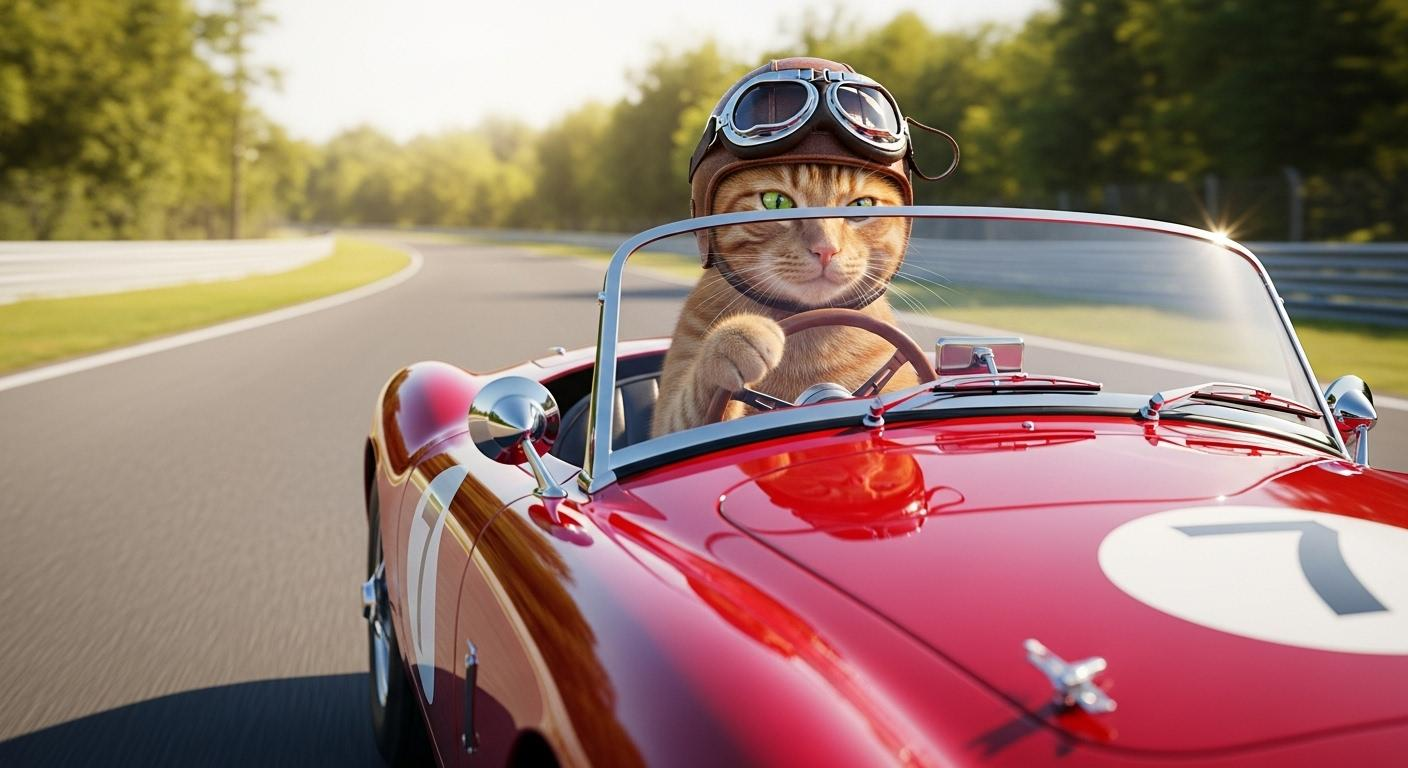

In [ ]:
if not I_am_aware_that_veo_is_a_paid_feature:
  print("Imagen is a paid feature. Please change the variable 'I_am_aware_that_veo_is_a_paid_feature' to True if you are okay with paying to run it.")

else:
  prompt = "A high quality photorealistic front image of a ginger cat driving a red convertible racing car"  # @param {type: "string"}

  # Optional parameters
  negative_prompt = "ugly, low quality, static, weird physics" # @param {type: "string"}
  aspect_ratio = "16:9"
  number_of_videos = 1


  result = client.models.generate_images(
      model="imagen-4.0-generate-preview-06-06",
      prompt=prompt,
      config=types.GenerateImagesConfig(
          number_of_images=1,
          output_mime_type="image/jpeg",
          aspect_ratio=aspect_ratio
          #negative_prompt=negativePrompt, # negative prompt is curently only supported by Veo
      )
  )

  result.generated_images[0].image.show()

When you are happy with your image, you can use Veo to make a video out of it.

In [ ]:
if not I_am_aware_that_veo_is_a_paid_feature:
  print("Veo is a paid feature. Please change the variable 'I_am_aware_that_veo_is_a_paid_feature' to True if you are okay with paying to run it.")

else:
  import time
  from IPython.display import Video, HTML

  # Optional parameters
  negative_prompt = "ugly, low quality, static, weird physics" # @param {type: "string"}
  aspect_ratio = "16:9" # @param ["16:9","9:16"]
  resolution = "1080p" # @param ["720p","1080p"]

  operation = client.models.generate_videos(
      model=VEO_MODEL_ID,
      prompt=prompt,
      image=types.Image(
          image_bytes=result.generated_images[0].image.image_bytes,
          mime_type="image/png"
      ),
      config=types.GenerateVideosConfig(
        # At the moment the config must not be empty
        aspect_ratio=aspect_ratio,
        resolution=resolution,
        number_of_videos=1, # 1 video generated per request
        negative_prompt=negative_prompt,
      ),
  )

  # Waiting for the video(s) to be generated
  while not operation.done:
      time.sleep(20)
      operation = client.operations.get(operation)
      print(operation)

  print(operation.result.generated_videos)

  for n, generated_video in enumerate(operation.result.generated_videos):
    client.files.download(file=generated_video.video)
    generated_video.video.save(f'video{n}.mp4') # Saves the video(s)
    display(generated_video.video.show()) # Display the video(s) in a notebook

##### Watch a sample generation 🎥

🍿 The video you will generate will be similar to this: [A video generated from the Imagen generated image](https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/video_from_imagen_img.mp4).

<video controls src="https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/video_from_imagen_img.mp4">

#### Maintaining character consistency

To maintain character consistency in a single shot, it can be helpful to provide multiple angles of your subject in the input image. In the example below, the input image provided to Veo shows a man looking straight at the camera, and then his left and right profile. This can help Veo to achieve more consistent output for actions like removing glasses, smiling, turning away from the camera, etc.

If you want to learn tips for mainting character consistency across multiple video clips, [check out this example](https://github.com/philschmid/gemini-samples/blob/main/scripts/gemini-veo-meta.py).

In [ ]:
import os

from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
  os.rename(fn, 'image.jpg')

Saving char_consistency_example.png to char_consistency_example.png


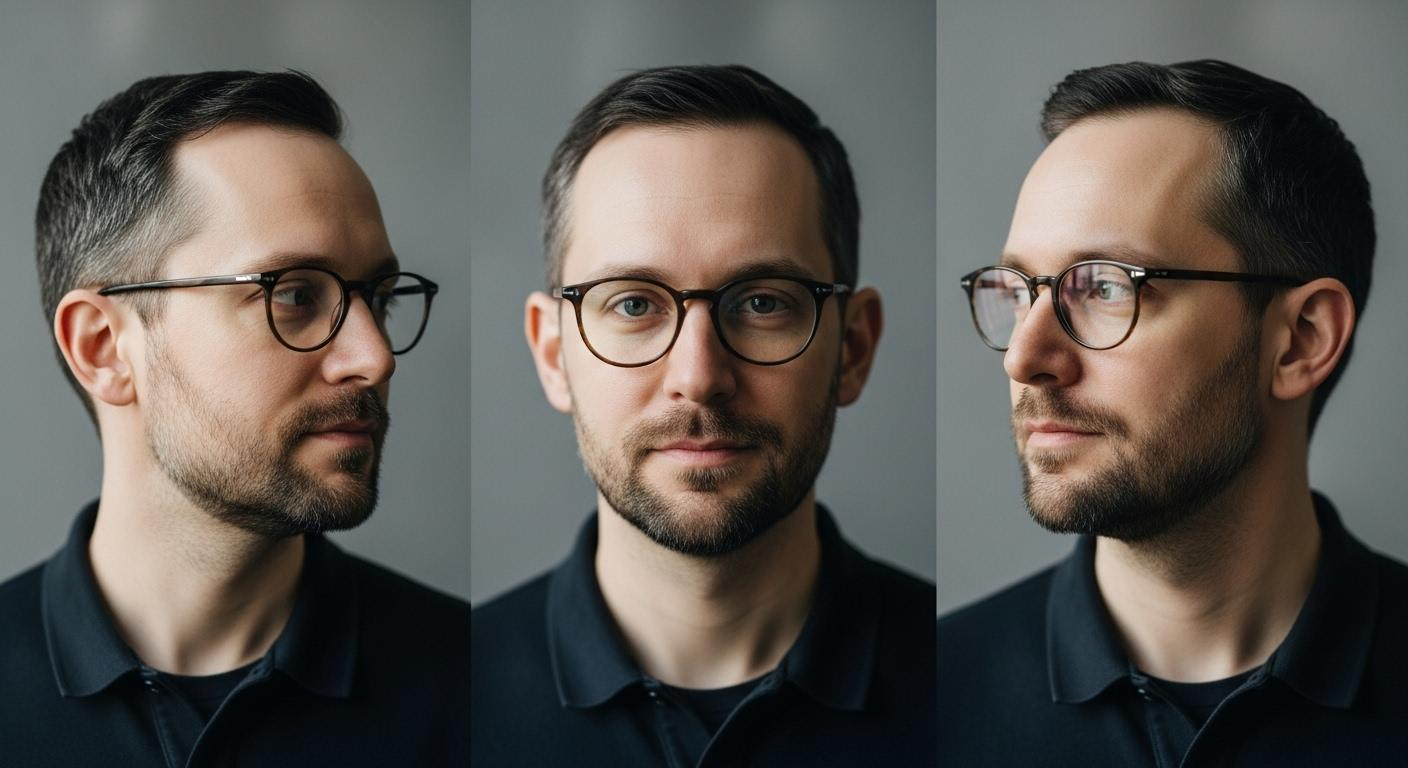

In [ ]:
from IPython.display import Image as Img

display(Img('image.jpg', width=600)) # display the uploaded image

In [ ]:
if not I_am_aware_that_veo_is_a_paid_feature:
  print("Veo is a paid feature. Please change the variable 'I_am_aware_that_veo_is_a_paid_feature' to True if you are okay with paying to run it.")

else:
  import time
  from google.genai import types
  from IPython.display import Video, HTML
  from PIL import Image
  import io

  prompt = "This is a view of a character (Joel) from multiple angles that you can use as a reference to generate a video of a head-on shot of Joel smiling, removing his glasses and winking at the camera one time. HDMR. 8K" # @param {type: "string"}
  image_name = "" # @param {type: "string", "placeholder":"Enter the name of your image or leave empty for the one you just uploaded."}

  # Optional parameters
  negative_prompt = "ugly, low quality, static, weird physics" # @param {type: "string"}
  aspect_ratio = "16:9" # @param ["16:9","9:16"]
  resolution = "1080p" # @param ["720p","1080p"]

  # Loading the image
  if image_name=="":
    image_name = "image.jpg"
  im = Image.open(image_name)

  # converting the image to bytes
  image_bytes_io = io.BytesIO()
  im.save(image_bytes_io, format=im.format)
  image_bytes = image_bytes_io.getvalue()

  operation = client.models.generate_videos(
      model=VEO_MODEL_ID,
      prompt=prompt,
      image=types.Image(image_bytes=image_bytes, mime_type=im.format),
      config=types.GenerateVideosConfig(
        # At the moment the config must not be empty
        aspect_ratio=aspect_ratio,
        resolution=resolution,
        number_of_videos=1, # 1 video generated per request
        negative_prompt=negative_prompt,
      ),
  )

  # Waiting for the video(s) to be generated
  while not operation.done:
      time.sleep(20)
      operation = client.operations.get(operation)
      print(operation)

  print(operation.result.generated_videos)

  for n, generated_video in enumerate(operation.result.generated_videos):
    client.files.download(file=generated_video.video)
    generated_video.video.save(f'video{n}.mp4') # Saves the video(s)
    display(generated_video.video.show()) # Displays the video(s) in a notebook

##### Watch a sample generation 🎥

🍿 The video you will generate will be similar to this: [A video generated of a man removing his glasses.](https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/character_consistency.mp4)

<video controls src="https://storage.googleapis.com/generativeai-downloads/gemini-cookbook/videos/character_consistency.mp4">

In [ ]:
# To prevent you from running the notebook by mistake
I_am_aware_that_veo_is_a_paid_feature = False

## Next Steps
### Useful API references:

Check the [Veo documentation](https://ai.google.dev/gemini-api/docs/video) and the [prompt guide](https://ai.google.dev/gemini-api/docs/video#prompt-guide) for more details on how to use Veo and best prompt it.

### Continue your discovery of the Gemini API

Here are other cool Gemini features that you might find interesting:
* [Imagen](./Get_started_Imagen.ipynb) can generate images with fine detail, rich lighting, and few distracting artifact from natural language prompts;
* Gemini's [Image-out](./Image-out.ipynb) built-in image output can also generate images and let you iterate on them by chatting with the model;
* Built-in [Audio-out](./Audio-out.ipynb) is also a great multimodal output capability that's quite fun to play with.